# TUD IS sentiment analysis tool
This notebook can be used as a tool for  Sentiment Analysis of Tweets from Twitter with the Google Natural Language API about given keywords.
## Preparations

Installation of python requirements

In [31]:
!pip install searchtweets-v2 google-cloud-language==2.2.2

You should consider upgrading via the 'C:\Users\Lukas\.virtualenvs\tud-is-sentiment-eogrpOkI\Scripts\python.exe -m pip install --upgrade pip' command.


In [32]:
import os
import time
from datetime import date, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
from google.cloud import language
from google.auth import load_credentials_from_file
from searchtweets import ResultStream, gen_request_parameters, load_credentials


## Input

The following parameters for the search are available:

- `start_time`: Starting date for the analysis
- `time_interval`: Interval in which new tweets are grouped together for sentiment analysis
- `time_steps`: Number of intervals to download
- `search_term`: Search Term
- `countries`: List of countries to download tweets for
- `languages`: List of languages to plot

In [33]:
start_time = date(2020, 1, 1)
time_interval = 7
time_steps = 52

search_term = 'artificial intelligence'
countries = ['US', 'DE', 'FR', 'ES', 'JP']
languages = ['en', 'de', 'fr', 'es', 'jp']

plotted_value = 'magnitude'#'sentiment' # 'magnitude', 'tweets'


### Preparations Google NLP-API
To authenticate against the Google NLP-API an enviromentvariable `GOOGLE_APPLICATION_CREDENTIALS` pointing to a credentials file must be present in the executing environment.

In addition the `analyze_text`-function uses a basic caching mechanism to save on API-Calls and network time.

In [34]:
cache_directory = 'cache'

# Instantiates a client
nlp_client = language.LanguageServiceClient(
    credentials=load_credentials_from_file('./credentials/tud-is-sentiment.json')[0])


def analyze_text(text, scope='document'):
    cache_path = os.path.join('.', cache_directory, '00-sentiment-cache.pckl')

    os.makedirs(os.path.dirname(cache_path), exist_ok=True)

    try:
        df = pd.read_pickle(cache_path)
    except FileNotFoundError:
        df = pd.DataFrame(columns=['text', 'scope', 'score', 'magnitude'])

    cache_result = df[(df.text == text) & (df.scope == scope)]

    if len(cache_result) == 1:
        return cache_result.iloc[0].score, cache_result.iloc[0].magnitude

    document = language.Document(
        content=text, type_=language.Document.Type.PLAIN_TEXT
    )

    f = nlp_client.analyze_entity_sentiment if scope == 'entity' else nlp_client.analyze_sentiment
    analysis = f(request={'document': document})

    df = df.append({
        'text': text,
        'scope': scope,
        'score': analysis.document_sentiment.score,
        'magnitude': analysis.document_sentiment.magnitude
    }, ignore_index=True)
    df.to_pickle(cache_path)

    return analysis.document_sentiment.score, analysis.document_sentiment.magnitude


### Preparations for Twitter-API
Tweets from twitter are fetched using the search-tweets library. To fetch tweets a `fetch-tweets`-function is defined that returns tweets for the query from a disk cache if possible.

[https://github.com/twitterdev/search-tweets-python/tree/v2](https://github.com/twitterdev/search-tweets-python/tree/v2)

In [35]:
twitter_credentials_filename = "./credentials/twitter-academic.yml"

search_args_all = load_credentials(
    filename=twitter_credentials_filename,
    yaml_key="search_all_tweets_v2"
)

search_args_recent = load_credentials(
    filename=twitter_credentials_filename,
    yaml_key="search_recent_tweets_v2"
)


def fetch_tweets(search_term, start_time=start_time, end_time=start_time + timedelta(days=time_interval), country="US", credentials=search_args_all, max_tweets=10000, skip_cache=False):
    query = "{} place_country:{} -is:retweet -has:links".format(search_term, country)
    filename = ''.join(
        l for l in "{} start_time={} end_time={}".format(query, start_time, end_time, country) if l not in [' ', ':']
    )

    cache_path = os.path.join('.', cache_directory, '{}.pckl'.format(filename))

    os.makedirs(os.path.dirname(cache_path), exist_ok=True)

    try:
        if skip_cache:
            raise FileNotFoundError()
        df = pd.read_pickle(cache_path)

    except FileNotFoundError:
        tweet_fields = [
            'id',
            'created_at',
            'text',
            'lang',
            'geo',
            'source'
        ]

        rs = ResultStream(
            request_parameters=gen_request_parameters(
                query,
                None,
                results_per_call=min(500, max_tweets),
                tweet_fields=','.join(tweet_fields),
                start_time=str(start_time),
                end_time=str(end_time)
            ),
            max_tweets=max_tweets,
            **credentials
        )
        
        df = pd.DataFrame(

            data=sum([page['data'] for page in rs.stream()], [])
        )

        df = df.convert_dtypes()
        try:
            df['created_at'] = pd.to_datetime(df['created_at'])
        except:
            pass

        df.to_pickle(cache_path)

    return df


In [36]:
df = None

for country in countries:
    end = start_time

    for week in range(time_steps):
        start = end
        end = start + timedelta(days=time_interval)
        tweets = fetch_tweets(
            search_term,
            start_time=start,
            end_time=end,
            country=country,
            max_tweets=100,
            skip_cache=False
        )
        print("country: {} week: {} start: {}, end: {} number of tweets: {}".format(
            country, week, start, end, len(tweets))
        )
        if df is None:
            df = tweets
        else:
            df = df.append(tweets, ignore_index=True)

print(len(df))
df.head()


country: US week: 0 start: 2020-01-01, end: 2020-01-08 number of tweets: 22
country: US week: 1 start: 2020-01-08, end: 2020-01-15 number of tweets: 29
country: US week: 2 start: 2020-01-15, end: 2020-01-22 number of tweets: 21
country: US week: 3 start: 2020-01-22, end: 2020-01-29 number of tweets: 20
country: US week: 4 start: 2020-01-29, end: 2020-02-05 number of tweets: 27
country: US week: 5 start: 2020-02-05, end: 2020-02-12 number of tweets: 22
country: US week: 6 start: 2020-02-12, end: 2020-02-19 number of tweets: 27
country: US week: 7 start: 2020-02-19, end: 2020-02-26 number of tweets: 13
country: US week: 8 start: 2020-02-26, end: 2020-03-04 number of tweets: 20
country: US week: 9 start: 2020-03-04, end: 2020-03-11 number of tweets: 19
country: US week: 10 start: 2020-03-11, end: 2020-03-18 number of tweets: 9
country: US week: 11 start: 2020-03-18, end: 2020-03-25 number of tweets: 13
country: US week: 12 start: 2020-03-25, end: 2020-04-01 number of tweets: 18
country: U

,geo,id,created_at,lang,text,source
0,{'place_id': '5c62ffb0f0f3479d'},1214554397620854785,2020-01-07 14:28:28+00:00,en,"@nytimes ""Facebook ban videos that are heavily...",Twitter for Android
1,{'place_id': 'a592bd6ceb1319f7'},1214458968338092033,2020-01-07 08:09:16+00:00,en,"Artificial intelligence, public health",Twitter for Android
2,{'place_id': '01c0441229f0e67f'},1214440173901099009,2020-01-07 06:54:35+00:00,en,@Xylious You uploading a artificial intelligen...,Twitter for iPhone
3,{'place_id': 'd90f907c3aac935c'},1214385508601794561,2020-01-07 03:17:22+00:00,en,@alexa99 So if you are artificially intelligen...,Twitter for Android
4,{'place_id': 'bd3d2074a33fbd06'},1214384726145978371,2020-01-07 03:14:15+00:00,en,Artificial Intelligence scares the shit out of me,Twitter for iPhone


In [37]:
sentiment_df = df[df.lang.isin(languages)].reset_index().groupby(
    'lang'
).resample('{}D'.format(time_interval), on='created_at').agg({'text': '. '.join, 'id': 'size'})


In [38]:
ds = []
print(len(sentiment_df.text))
for i, row in enumerate(sentiment_df.text):
    print(i)
    try:
        s = analyze_text(row)
        ds.append(s)
    except:
        ds.append((0, 0))

scores, magnitudes = zip(*ds)

sentiment_df['score'] = scores
sentiment_df['magnitude'] = magnitudes

sentiment_df.head()

132
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131


text  \
lang created_at                                                                     
de   2020-03-30 00:00:00+00:00  @M_T_Franz Irrtum: je mehr mathematisch-statis...   
     2020-04-06 00:00:00+00:00  @nutellaberliner @TomKlindt The mystery of art...   
en   2020-01-01 00:00:00+00:00  @TheRealSusanA1 @catahoulasrule @flowerPotzzz ...   
     2020-01-08 00:00:00+00:00  god i miss artificial intelligence bomb. @trut...   
     2020-01-15 00:00:00+00:00  Bernie Sanders talking about using the power o...   

                                id  score  magnitude  
lang created_at                                       
de   2020-03-30 00:00:00+00:00   1    0.3   0.900000  
     2020-04-06 00:00:00+00:00   1    0.0   0.100000  
en   2020-01-01 00:00:00+00:00  20   -0.2  17.100000  
     2020-01-08 00:00:00+00:00  30    0.0  23.700001  
     2020-01-15 00:00:00+00:00  18   -0.2  21.900000

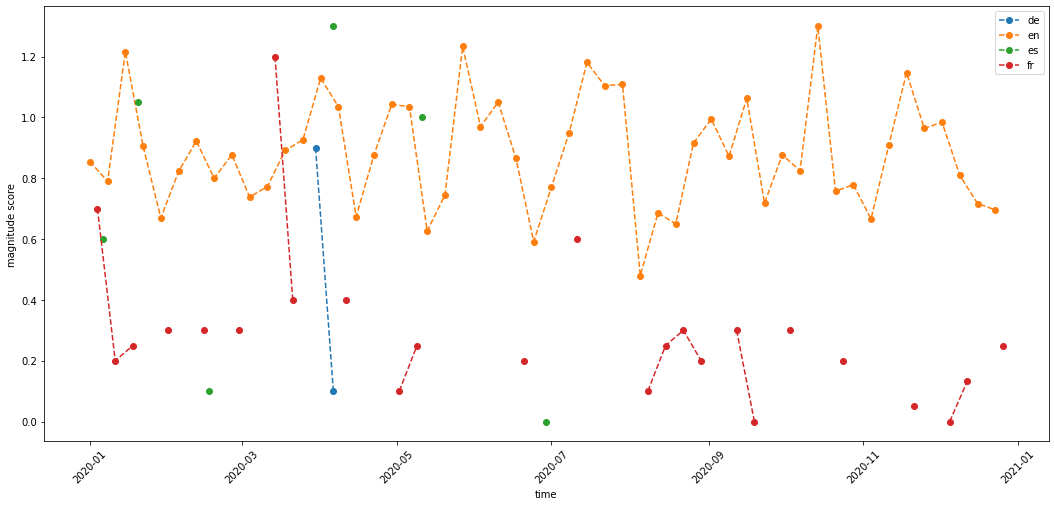

In [39]:
fig,ax = plt.subplots(figsize=(18, 8))

languages = sentiment_df.index.levels[0]
for lang in languages:
    if plotted_value == 'sentiment':
        ax.plot(sentiment_df.loc[(lang)].score, 'o-', label=lang)
        ax.set_ylabel("sentiment score")
    elif plotted_value == 'magnitude':
        ax.plot(sentiment_df.loc[(lang)].magnitude / sentiment_df.loc[(lang)].id, 'o--', label=lang)
        ax.set_ylabel("magnitude score")
    else:
        ax.plot(sentiment_df.loc[(lang)].id, 'o--', label=lang)
        ax.set_ylabel("number of tweets")

ax.set_xlabel("time")
ax.legend(loc='best')
plt.xticks(rotation=45)
plt.show()